In [1]:
# OPTIONAL - sets the cells width of current notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [1]:
# import all necessary torch libraries
import torch
import torch.nn as nn
# sets output as wide as possible
torch.set_printoptions(edgeitems=30, linewidth=100000)
# data initialization
from dlc_practical_prologue import generate_pair_sets
nSamples = 1000
#data = generate_pair_sets(nSamples)
#var_names = ["train_input", "train_target", "train_classes", "test_input", "test_target", "test_classes"]
#train_input, train_target, train_classes, test_input, test_target, test_classes = data
#stringWidth = 20
#for i, el in enumerate(list(map(lambda x: (x.shape, x.dtype), data))):
#    print('{:s}  {:s}  {:s}'.format(
#        var_names[i].ljust(stringWidth),
#        ' x '.join(list(map(lambda x: str(x), list(el[0])))).center(stringWidth), 
#        'dtype'.ljust(stringWidth)))

## ConvNet

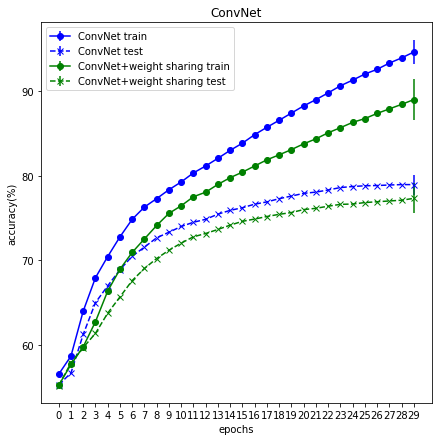

ConvNet final test accuracy: 78.98 ± 1.18 %
ConvNet + weight sharing final test accuracy: 77.35 ± 1.76 %
CPU times: user 8min 57s, sys: 5.62 s, total: 9min 3s
Wall time: 2min 19s


In [11]:
%%time

from models.convnet import ConvNet
from utils import train_model
from utils import visualize_accuracy
from utils import calculate_mean_std

nb_epochs = 30
mini_batch_size = 100
#lrs = [0.000247, 0.000213]
lrs = [1e-4, 1e-4]
ws = [False, True]
formats = [['b-o', 'b--x'], ['g-o', 'g--x']]
labels = [['ConvNet train', 'ConvNet test'], 
          ['ConvNet+weight sharing train', 'ConvNet+weight sharing test']]
final_acc = [[0, 0], [0, 0]]

# initialize plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 7))
plt.xlabel('epochs')
plt.ylabel('accuracy(%)')
plt.xticks(range(nb_epochs))

for k in [0, 1]:

    # average acuracy of the model over nb_iter runs
    nb_iter = 10
    train_accuracies = torch.tensor([])
    test_accuracies = torch.tensor([])
    train_losses = []
    
    for i in range(nb_iter):

        # create model & optimizer
        model = ConvNet(nb_channels=24, kernel_size=3, weight_sharing=ws[k])
        optimizer = torch.optim.Adam(model.parameters(), lr = lrs[k])
        criterion = nn.BCELoss()            

        # load data
        train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(nSamples)
        # pad input to size 16 x 16 (power of 2, so that it can be run through 3 max-pool layers)
        train_input_cnn = torch.nn.functional.pad(train_input, (1, 1, 1, 1), 'constant', 0)
        test_input_cnn = torch.nn.functional.pad(test_input, (1, 1, 1, 1), 'constant', 0)

        # train model
        train_accuracy, test_accuracy, train_loss = train_model(model, 
                                                train_input_cnn, train_target.float(),
                                                test_input_cnn, test_target,
                                                nb_epochs, mini_batch_size,
                                                optimizer, criterion)
        
        # add accuracy stats
        train_accuracies = torch.cat([train_accuracies, train_accuracy], dim=0)
        test_accuracies = torch.cat([test_accuracies, test_accuracy], dim=0)
        #train_losses.append(train_loss)
        
    # calculate mean & std over nb_iters runs
    train_mean, train_std, test_mean, test_std = calculate_mean_std(train_accuracies, test_accuracies, train_losses)
    
    # plot accuracy of the model
    plt.errorbar(range(nb_epochs), train_mean, yerr=train_std, fmt=formats[k][0], label=labels[k][0])
    plt.errorbar(range(nb_epochs), test_mean, yerr=test_std, fmt=formats[k][1], label=labels[k][1])
    
    # final accuracy
    final_acc[k][0] = test_mean[-1]
    final_acc[k][1] = test_std[-1]
        
# show plot
plt.legend(loc="upper left")
plt.title("ConvNet")
plt.show()
# final test accuracy
print("ConvNet final test accuracy: {:.2f} \u00B1 {:.2f} %".format(final_acc[0][0],
                                                                   final_acc[0][1]))
print("ConvNet + weight sharing final test accuracy: {:.2f} \u00B1 {:.2f} %".format(final_acc[1][0],
                                                                                    final_acc[1][1]))

In [67]:
from utils import num_of_train_param
num_of_train_param(model)

The model has 29833 trainable parameters


## Net1

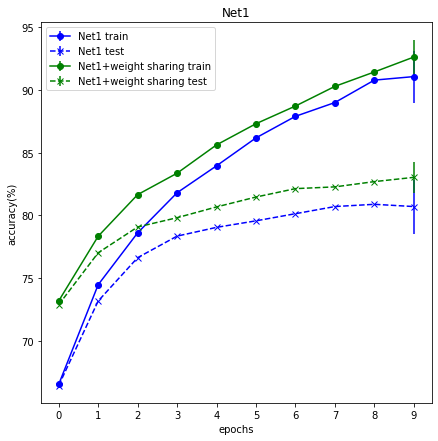

Net1 final test accuracy: 80.71 ± 2.16 %
Net1 + weight sharing final test accuracy: 83.04 ± 1.21 %
CPU times: user 3min 16s, sys: 3.41 s, total: 3min 20s
Wall time: 53.7 s


In [19]:
%%time

from utils import train_model
from utils import visualize_accuracy
from models.net1 import Net1

# initialize parameters
mini_batch_size = 100
nb_epochs = 10
etas = [0.000483, 0.000399]
ws = [False, True]
formats = [['b-o', 'b--x'], ['g-o', 'g--x']]
labels = [['Net1 train', 'Net1 test'], 
          ['Net1+weight sharing train', 'Net1+weight sharing test']]
final_acc = [[0, 0], [0, 0]]

# initialize plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 7))
plt.xlabel('epochs')
plt.ylabel('accuracy(%)')
plt.xticks(range(nb_epochs))

for k in [0, 1]:

    # average acuracy of the model over nb_iter runs
    nb_iter = 10
    train_accuracies = torch.tensor([])
    test_accuracies = torch.tensor([])
    train_losses = []
    
    for i in range(nb_iter):

        # create model & optimizer
        model = Net1(weight_sharing=ws[k])
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = etas[k])

        # load data
        train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(nSamples)

        # train model
        train_accuracy, test_accuracy, _ = train_model(model, 
                                                       train_input, train_target.float(),
                                                       test_input, test_target,
                                                       nb_epochs, mini_batch_size,
                                                       optimizer, criterion)

        # add accuracy stats
        train_accuracies = torch.cat([train_accuracies, train_accuracy], dim=0)
        test_accuracies = torch.cat([test_accuracies, test_accuracy], dim=0)
        #train_losses.append(train_loss)
        
    # calculate mean & std over nb_iters runs
    train_mean, train_std, test_mean, test_std = calculate_mean_std(train_accuracies, test_accuracies, train_losses)
    
    # plot accuracy of the model
    plt.errorbar(range(nb_epochs), train_mean, yerr=train_std, fmt=formats[k][0], label=labels[k][0])
    plt.errorbar(range(nb_epochs), test_mean, yerr=test_std, fmt=formats[k][1], label=labels[k][1])
    
    # final accuracy
    final_acc[k][0] = test_mean[-1]
    final_acc[k][1] = test_std[-1]
    
# show plot
plt.legend(loc="upper left")
plt.title("Net1")
plt.show()
# final test accuracy
print("Net1 final test accuracy: {:.2f} \u00B1 {:.2f} %".format(final_acc[0][0],
                                                                final_acc[0][1]))
print("Net1 + weight sharing final test accuracy: {:.2f} \u00B1 {:.2f} %".format(final_acc[1][0],
                                                                                 final_acc[1][1]))

In [4]:
from utils import num_of_train_param
num_of_train_param(model)

The model has 24425 trainable parameters


## Net2

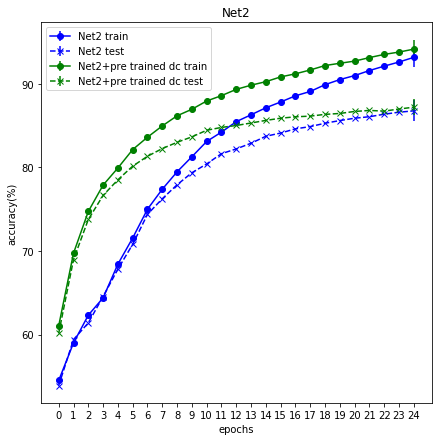

Net2 final test accuracy: 86.75 ± 1.26 %
Net2 + pre-trained dc final test accuracy: 87.19 ± 0.97 %
CPU times: user 10min 1s, sys: 6.8 s, total: 10min 7s
Wall time: 2min 35s


In [6]:
%%time

from utils import train_model
from utils import train_model_double_objective
from utils import accuracy_of_digit_class
from utils import dfs_freeze
from utils import calculate_mean_std
from models.net2 import Net2
from models.digit_classifier import DigitClassifier

# digit classifier params
mini_batch_size_dc = 100
eta_dc = 1e-3
nb_epochs_dc = 20
# net2 params
mini_batch_size = 100
nb_epochs = 25
etas = [0.000483, 0.000263, 5e-4]
pre_train = [False, True, True]
formats = [['b-o', 'b--x'], ['g-o', 'g--x'], ['r-o', 'r--x']]
labels = [['Net2 train', 'Net2 test'], 
          ['Net2+pre trained dc train', 'Net2+pre trained dc test'],
          ['Net2+freeze dc train', 'Net2+freeze dc test']]
final_acc = [[0, 0], [0, 0], [0, 0]]

# initialize plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 7))
plt.xlabel('epochs')
plt.ylabel('accuracy(%)')
plt.xticks(range(nb_epochs))

for k in [0, 1]:

    # average acuracy of the model over nb_iter runs
    nb_iter = 10
    train_accuracies = torch.tensor([])
    test_accuracies = torch.tensor([])
    train_losses = []
    
    for i in range(nb_iter):
        
        # pre-train digit classifier
        model_classifier = None
        train_input, train_target, train_classes, test_input, test_target, test_classes = None, None, None, None, None, None
        if pre_train[k]:
            
            # create digit classifier model & optimizer
            model_classifier = DigitClassifier(out_h = 10, subnet = False)
            optimizer = torch.optim.Adam(model_classifier.parameters(), lr = eta_dc)
            criterion = nn.CrossEntropyLoss()

            # load data
            train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(nSamples)

            # data for digit classifier
            train_in = train_input[:, 0, :, :].unsqueeze(axis = 1)
            train_class = train_classes[:,0]
            test_in = test_input[:, 0, :, :].unsqueeze(axis = 1)
            test_class = test_classes[:,0]

            # train digit classifier model
            train_accuracy_dc, test_accuracy_dc, train_loss_dc = train_model(model_classifier, 
                                                                             train_in, train_class,
                                                                             test_in, test_class,
                                                                             nb_epochs_dc, mini_batch_size_dc, 
                                                                             optimizer, criterion)

        # create model & optimizer
        if k==2:
            dfs_freeze(model_classifier)
        model = Net2(pretrained_submodel = model_classifier)
        criterion = nn.BCEWithLogitsLoss()
        criterion2 = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = etas[k])

        # load data
        if not pre_train[k]:
            train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(nSamples)

        # train model
        train_accuracy, test_accuracy, _ = train_model_double_objective(model, train_input, train_target.float(), 
                                                         train_classes, test_input, test_target, 
                                                         test_classes, nb_epochs, mini_batch_size, optimizer, 
                                                         criterion, criterion2, beta = 1)

        # add accuracy stats
        train_accuracies = torch.cat([train_accuracies, train_accuracy], dim=0)
        test_accuracies = torch.cat([test_accuracies, test_accuracy], dim=0)
        #train_losses.append(train_loss)

    # calculate mean & std over nb_iters runs
    train_mean, train_std, test_mean, test_std = calculate_mean_std(train_accuracies, test_accuracies, train_losses)

    # plot accuracy of the model
    plt.errorbar(range(nb_epochs), train_mean, yerr=train_std, fmt=formats[k][0], label=labels[k][0])
    plt.errorbar(range(nb_epochs), test_mean, yerr=test_std, fmt=formats[k][1], label=labels[k][1])
    
    # final accuracy
    final_acc[k][0] = test_mean[-1]
    final_acc[k][1] = test_std[-1]
    
# show plot
plt.legend(loc="upper left")
plt.title("Net2")
plt.show()
# final test accuracy
print("Net2 final test accuracy: {:.2f} \u00B1 {:.2f} %".format(final_acc[0][0],
                                                                final_acc[0][1]))
print("Net2 + pre-trained dc final test accuracy: {:.2f} \u00B1 {:.2f} %".format(final_acc[1][0],
                                                                                 final_acc[1][1])) 
#print("Net2 + pre-trained dc + frozen final test accuracy: {:.2f} \u00B1 {:.2f} %".format(final_acc[2][0],
#                                                                                          final_acc[2][1])) 

## Everything below probably not needed

In [11]:
from utils import train_model
from utils import train_model_double_objective
from utils import dfs_freeze
from utils import accuracy_of_digit_class
from models.digit_classifier import DigitClassifier
from models.net2 import Net2

# digit classifier params
mini_batch_size_dc = 100
eta_dc = 1e-3
nb_epochs_dc = 20
# net2 params
eta_net2 = 1e-3
mini_batch_size_net2 = 10
nb_epochs_net2 = 10

# average acuracy of the model over nb_iter runs
nb_iter = 10
train_accuracies_dc, test_accuracies_dc, train_losses_dc = [], [], []
train_accuracies_net2, test_accuracies_net2, train_losses_net2 = [], [], []
dc_accuracy_post_train = []
for i in range(nb_iter):
    
    # create digit classifier model & optimizer
    model_classifier = DigitClassifier(out_h = 10, subnet = False)
    optimizer = torch.optim.Adam(model_classifier.parameters(), lr = eta_dc)
    criterion = nn.CrossEntropyLoss()

    # load data
    train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(nSamples)
    
    # data for digit classifier
    train_in = train_input[:, 0, :, :].unsqueeze(axis = 1)
    train_class = train_classes[:,0]
    test_in = test_input[:, 0, :, :].unsqueeze(axis = 1)
    test_class = test_classes[:,0]

    # train digit classifier model
    train_accuracy_dc, test_accuracy_dc, train_loss_dc = train_model(model_classifier, 
                                                            train_in, train_class,
                                                            test_in, test_class,
                                                            nb_epochs_dc, mini_batch_size_dc, 
                                                            optimizer, criterion)
    
    # add digit classifier accuracy stats
    train_accuracies_dc.append(train_accuracy_dc)
    test_accuracies_dc.append(test_accuracy_dc)
    train_losses_dc.append(train_loss_dc)
    
    # create net2 model & optimizer
    # freeze weights of pre-trained digit classifier
    #dfs_freeze(model_classifier)
    model = Net2(model_classifier)
    criterion = nn.BCEWithLogitsLoss()
    criterion2 = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=eta_net2)
    
    # train net2 model
    train_accuracy_net2, test_accuracy_net2, train_loss_net2 = train_model_double_objective(model, train_input, train_target.float(), 
                                                             train_classes, test_input, test_target, 
                                                             test_classes, nb_epochs, mini_batch_size, optimizer, 
                                                             criterion, criterion2, beta = 1)
    
    # add net2 accuracy stats
    train_accuracies_net2.append(train_accuracy_net2)
    test_accuracies_net2.append(test_accuracy_net2)
    train_losses_net2.append(train_loss_net2)
    
    # accuracy of digit classifier after training net2
    dc_accuracy_post_train.append(accuracy_of_digit_class(model, test_input, test_classes))
    


NameError: name 'visualize_accuracy' is not defined

In [13]:
visualize_accuracy(train_accuracies_dc, test_accuracies_dc, train_losses_dc)
visualize_accuracy(train_accuracies_net2, test_accuracies_net2, train_losses_net2)
mean_dc_accuracy_post_train = torch.mean(torch.tensor(dc_accuracy_post_train))
print("Accuracy of digit classifier after training net2 is on average: {:.2f}".format(mean_dc_accuracy_post_train))

ValueError: only one element tensors can be converted to Python scalars

In [12]:
def visualize_accuracy(train_accs, test_accs, train_losses):
    train_accs = torch.tensor(train_accs)
    test_accs = torch.tensor(test_accs)
    #train_losses = torch.tensor(train_losses)
    train_mean = torch.mean(train_accs, dim=0)
    test_mean = torch.mean(test_accs, dim=0)
    train_std = torch.zeros(size=train_mean.shape)
    train_std[-1] = torch.std(train_accs[:, -1])
    test_std = torch.zeros(size=test_mean.shape)
    test_std[-1] = torch.std(test_accs[:, -1])
    #loss_std, loss_mean = torch.std_mean(train_losses, dim=0)
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7, 7))
    plt.xlabel('epochs')
    plt.ylabel('accuracy(%)')
    nb_epochs = train_accs.shape[1]
    plt.xticks(range(nb_epochs))
    plt.errorbar(range(nb_epochs), train_mean, yerr=train_std, fmt='b-o', label="train")
    plt.errorbar(range(nb_epochs), test_mean, yerr=test_std, fmt='g-o', label="test")
    #plt.errorbar(range(nb_epochs), loss_mean, yerr=loss_std, fmt='r-o')
    plt.legend(loc="upper left")
    plt.show()

In [5]:
from utils import num_of_train_param
num_of_train_param(model)

The model has 11 trainable parameters


## Net3

In [17]:
from utils import train_model
from utils import train_model_double_objective
from utils import dfs_freeze
from utils import accuracy_of_digit_class
from models.digit_classifier import DigitClassifier
from models.net3 import Net3

# digit classifier params
mini_batch_size_dc = 100
eta_dc = 1e-3
nb_epochs_dc = 20
# net3 params
eta_net3 = 1e-3
mini_batch_size_net3 = 100
nb_epochs_net3 = 20

# average acuracy of the model over nb_iter runs
nb_iter = 10
train_accuracies_dc, test_accuracies_dc, train_losses_dc = [], [], []
train_accuracies_net3, test_accuracies_net3, train_losses_net3 = [], [], []
dc_accuracy_post_train = []
for i in range(nb_iter):
    
    # create digit classifier model & optimizer
    model_classifier = DigitClassifier(out_h = 10, subnet = False)
    optimizer = torch.optim.Adam(model_classifier.parameters(), lr = eta_dc)
    criterion = nn.CrossEntropyLoss()

    # load data
    train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(nSamples)
    
    # data for digit classifier
    train_in = train_input[:, 0, :, :].unsqueeze(axis = 1)
    train_class = train_classes[:,0]
    test_in = test_input[:, 0, :, :].unsqueeze(axis = 1)
    test_class = test_classes[:,0]
    
    # train digit classifier model
    train_accuracy_dc, test_accuracy_dc, train_loss_dc = train_model(model_classifier, 
                                                            train_in, train_class,
                                                            test_in, test_class,
                                                            nb_epochs_dc, mini_batch_size_dc, 
                                                            optimizer, criterion)
    
    # add digit classifier accuracy stats
    train_accuracies_dc.append(train_accuracy_dc)
    test_accuracies_dc.append(test_accuracy_dc)
    train_losses_dc.append(train_loss_dc)
    
    # create net3 model & optimizer
    # freeze weights of pre-trained digit classifier
    #dfs_freeze(model_classifier)
    model = Net3(nb_residual_blocks = 20, pretrained_submodel = model_classifier,
                 c1 = 32, c2 = 32, c3 = 64, h = 100, p = 0.3,
                 hidden_channel_1 = 1, hidden_channel_2 = 10)
    criterion = nn.BCEWithLogitsLoss()
    criterion2 = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = eta_net3)
    
    # train net3 model
    train_accuracy_net3, test_accuracy_net3, train_loss_net3 = train_model_double_objective(model, train_input, train_target, 
                                                                     train_classes, test_input, test_target, test_classes, 
                                                                     nb_epochs_net3, mini_batch_size_net3, optimizer, criterion, criterion2, 
                                                                     beta = 1)
    
    # add net3 accuracy stats
    train_accuracies_net3.append(train_accuracy_net3)
    test_accuracies_net3.append(test_accuracy_net3)
    train_losses_net3.append(train_loss_net3)
    
    # accuracy of digit classifier after training net3
    dc_accuracy_post_train.append(accuracy_of_digit_class(model, test_input, test_classes))
    
visualize_accuracy(train_accuracies_dc, test_accuracies_dc, train_losses_dc)
visualize_accuracy(train_accuracies_net3, test_accuracies_net3, train_losses_net3)
mean_dc_accuracy_post_train = torch.mean(torch.tensor(dc_accuracy_post_train))
print("Accuracy of digit classifier after training net2 is on average: {:.2f}".format(mean_dc_accuracy_post_train))   

KeyboardInterrupt: 

In [ ]:
from utils import num_of_train_param
num_of_train_param(model)